<a href="https://colab.research.google.com/github/olufunmiruth/g05-used-cars/blob/master/preprocessing_used_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "countessolufunmi" 
os.environ['KAGGLE_KEY'] = "da7d7c0b6f0bc05afa5cf56aa66fcb26" 
!kaggle datasets download -d austinreese/craigslist-carstrucks-data 

craigslist-carstrucks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/craigslist-carstrucks-data.zip

Archive:  /content/craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: vehicles.csv            


In [ ]:
!pip install catboost

In [ ]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [ ]:
# Loading necessary libraries
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
import datetime

In [ ]:
# load dataset
df = pd.read_csv('/content/vehicles.csv')
df.head(3)

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


In [ ]:
#check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [ ]:
# free up memory space
import gc
gc.collect()

0

In [ ]:
# add new column 'car_age'
current_time = datetime.datetime.now()
df['car_age'] = current_time.year - df['year']

In [ ]:

# Change the datatype of the year
df['year'] = df['year'].astype('str')

In [ ]:
# Split the dataset based on data type for easier preprocessing
num = df.select_dtypes(include=['int64', 'float64'])
cat = df.select_dtypes(include=['object'])
cat.head(2)

,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,posting_date
0,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,2020-12-02T08:11:30-0600
1,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,2020-12-02T02:11:50-0600


In [ ]:

# categorical features info
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           458213 non-null  object
 1   region        458213 non-null  object
 2   region_url    458213 non-null  object
 3   year          458213 non-null  object
 4   manufacturer  439993 non-null  object
 5   model         453367 non-null  object
 6   condition     265273 non-null  object
 7   cylinders     287073 non-null  object
 8   fuel          454976 non-null  object
 9   title_status  455636 non-null  object
 10  transmission  455771 non-null  object
 11  VIN           270664 non-null  object
 12  drive         324025 non-null  object
 13  size          136865 non-null  object
 14  type          345475 non-null  object
 15  paint_color   317370 non-null  object
 16  image_url     458185 non-null  object
 17  description   458143 non-null  object
 18  state         458213 non

In [ ]:
# Check for missing values in the categorical features
cat.isnull().sum()

url                  0
region               0
region_url           0
year                 0
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
title_status      2577
transmission      2442
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url           28
description         70
state                0
posting_date        28
dtype: int64

In [ ]:
# Check for missing values within the numerical features
num.isnull().sum()

Unnamed: 0        0
id                0
price             0
odometer      55303
lat            7448
long           7448
car_age        1050
dtype: int64

In [ ]:
# Fill missing values for longitude and latitude with zero

num['lat'] = num['lat'].fillna(0)

num['long'] = num['long'].fillna(0)

In [ ]:

# Import and instantiate the KNNImputer

from sklearn.impute import KNNImputer
num_imp = KNNImputer()

In [ ]:

#check head
num.head(2)

,Unnamed: 0,id,price,odometer,lat,long,car_age
0,0,7240372487,35990,32742.0,32.5900,-85.4800,10.0
1,1,7240309422,7500,93600.0,32.5475,-85.4682,6.0


In [ ]:
# Impute missing values for the odometer feature
num['odometer_trans'] = num_imp.fit_transform(num[['odometer']])

In [ ]:
# Impute missing values for the car_age feature
num['car_age_trans'] = num_imp.fit_transform(num[['car_age']])

In [ ]:
# Create 3 dimensional coordinates from latitude and longitude features

num['point_x'] = np.cos(num['lat']) * np.cos(num['long'])
num['point_y'] =np.cos(num['lat']) * np.sin(num['long'])
num['point_z'] = np.sin(num['lat'])

In [ ]:
#check top 2 rows
num.head(2)

,Unnamed: 0,id,price,odometer,lat,long,car_age,odometer_trans,car_age_trans,point_x,point_y,point_z
0,0,7240372487,35990,32742.0,32.5900,-85.4800,10.0,32742.0,10.0,-0.305961,0.235990,0.922332
1,1,7240309422,7500,93600.0,32.5475,-85.4682,6.0,93600.0,6.0,-0.339755,0.255719,0.905082


In [ ]:
# Create a list of the original numerical features
num_col = ['odometer', 'lat', 'long']

In [ ]:
# create a function to impute the missing values for categorical features

def impute_nan_add_vairable(DataFrame,ColName):
    #1. add new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"] =   np.where(DataFrame[ColName].isnull(),1,0)
    
    # 2. Take most occured category in that variable (.mode())
    
    Mode_Category = DataFrame[ColName].mode()[0]
    
    # 2.1 Replace NAN values with most occured category in actual vairable
    
    DataFrame[ColName].fillna(Mode_Category,inplace=True)


In [ ]:
#check columns
cat.columns

Index(['url', 'region', 'region_url', 'year', 'manufacturer', 'model',
       'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'image_url', 'description',
       'state', 'posting_date'],
      dtype='object')

In [ ]:
(cat['size'].isnull().sum()/cat.shape[0]) * 100

70.13070340649435

In [ ]:
#check for missing values in the region column
cat.region.isnull().sum()

0

In [ ]:
# Drop size column because of the volume of missing values
#Drop posting_date column due to irrelevance

cat = cat.drop(['size', 'posting_date'], axis=1)

In [ ]:
# Call function to impute NAN values and add new importance feature
colls = ['year', 'manufacturer', 'model', 'condition', 'cylinders','fuel',
         'title_status', 'transmission', 'drive', 'type', 'paint_color']

for Columns in colls:
    impute_nan_add_vairable(cat,Columns)

In [ ]:
gc.collect()

114

In [ ]:
cat.head(2)

,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,type,paint_color,image_url,description,state,year_Imputed,manufacturer_Imputed,model_Imputed,condition_Imputed,cylinders_Imputed,fuel_Imputed,title_status_Imputed,transmission_Imputed,drive_Imputed,type_Imputed,paint_color_Imputed
0,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,1G1YU3DW1A5106980,rwd,other,white,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,0,0,0,0,0,0,0,0,0,0,1
1,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,5NPEC4AB0EH813529,fwd,sedan,white,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Drop the original numerical features
num_main = num.drop(num_col, axis=1)

In [ ]:
num_main.head(2)

,Unnamed: 0,id,price,car_age,odometer_trans,car_age_trans,point_x,point_y,point_z
0,0,7240372487,35990,10.0,32742.0,10.0,-0.305961,0.235990,0.922332
1,1,7240309422,7500,6.0,93600.0,6.0,-0.339755,0.255719,0.905082


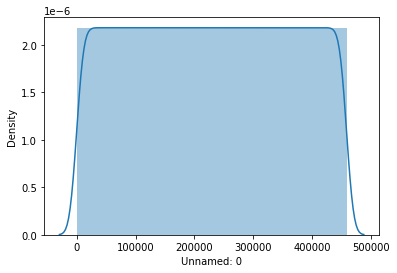

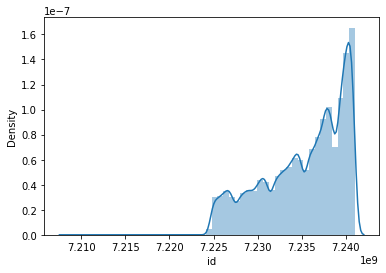

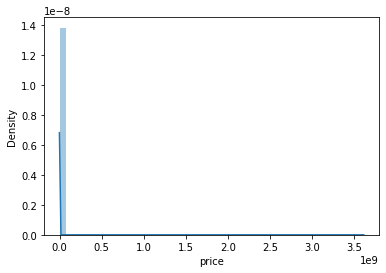

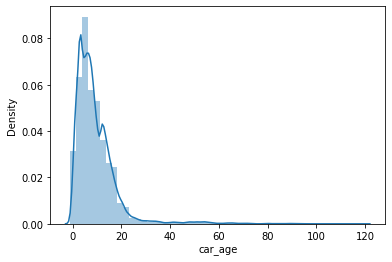

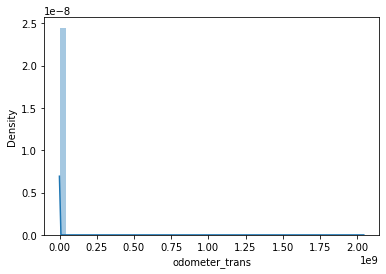

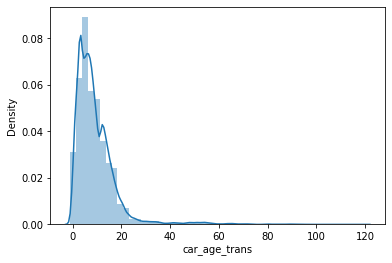

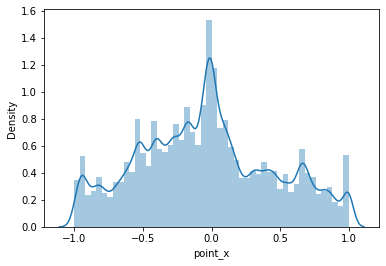

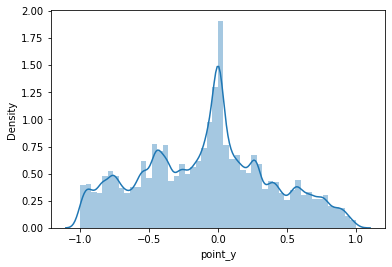

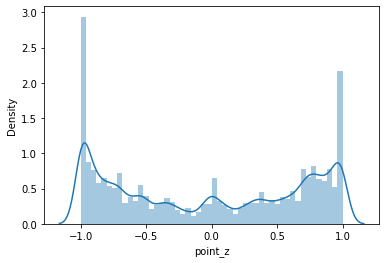

In [ ]:
#create visualisation
for i in num_main.columns:
    sns.distplot(num_main[i])
    plt.show()

In [ ]:
# Drop the original numerical feature-car_age
num_main = num_main.drop(['car_age'], axis=1)

In [ ]:
num_main.columns

Index(['Unnamed: 0', 'id', 'price', 'odometer_trans', 'car_age_trans',
       'point_x', 'point_y', 'point_z'],
      dtype='object')

In [ ]:
gc.collect()

52519

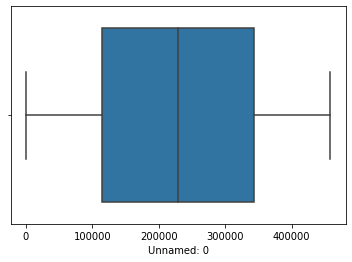

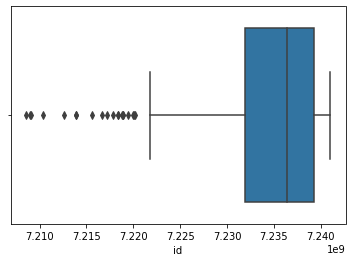

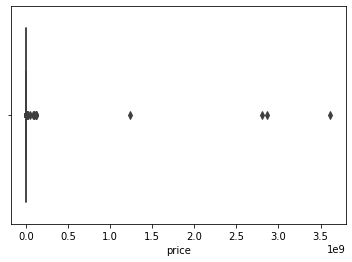

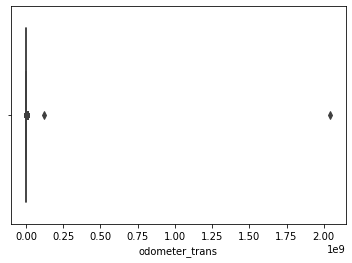

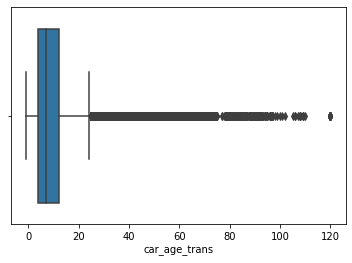

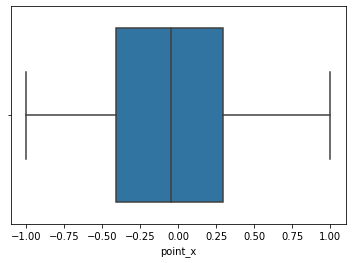

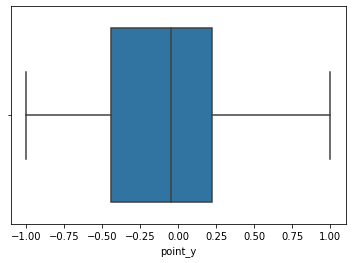

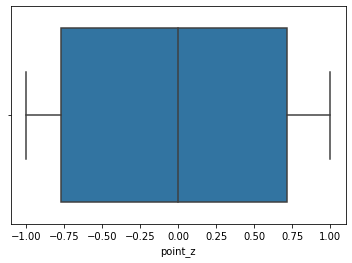

In [ ]:
# create visualsations
for v in num_main.columns:
    sns.boxplot(num_main[v])
    plt.show()

In [ ]:
# Import robust scaler from sklearn to scale numerical features
from sklearn.preprocessing import RobustScaler

In [ ]:
#robust scaling was performed  on the selected numerical features

sc_col = ['car_age_trans', 'odometer_trans']

rs = RobustScaler()

for named in sc_col:
    num_main[named] = rs.fit_transform(num_main[[named]])

In [ ]:
num_main.head(2)

,Unnamed: 0,id,price,odometer_trans,car_age_trans,point_x,point_y,point_z
0,0,7240372487,35990,-0.828596,0.375,-0.305961,0.235990,0.922332
1,1,7240309422,7500,-0.069958,-0.125,-0.339755,0.255719,0.905082


In [ ]:
# Join the numerical and categorical dataframes 

df = pd.concat([num_main, cat], axis=1)
df.shape

(458213, 37)

In [ ]:
gc.collect()

20532

In [ ]:
df.head()

,Unnamed: 0,id,price,odometer_trans,car_age_trans,point_x,point_y,point_z,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,type,paint_color,image_url,description,state,year_Imputed,manufacturer_Imputed,model_Imputed,condition_Imputed,cylinders_Imputed,fuel_Imputed,title_status_Imputed,transmission_Imputed,drive_Imputed,type_Imputed,paint_color_Imputed
0,0,7240372487,35990,-0.828596,0.375,-0.305961,0.235990,0.922332,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,clean,other,1G1YU3DW1A5106980,rwd,other,white,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,0,0,0,0,0,0,0,0,0,0,1
1,1,7240309422,7500,-0.069958,-0.125,-0.339755,0.255719,0.905082,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,2014.0,hyundai,sonata,excellent,4 cylinders,gas,clean,automatic,5NPEC4AB0EH813529,fwd,sedan,white,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,0,0,0,0,0,0,0,0,0,0,1
2,2,7240224296,4900,-0.151658,0.875,-0.289739,0.216241,0.932358,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,clean,automatic,NaN,4wd,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,0,0,0,0,0,0,0,0,1,0,0
3,3,7240103965,2000,1.131738,4.875,-0.115278,0.047804,0.992182,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,1974.0,chevrolet,c-10,good,4 cylinders,gas,clean,automatic,NaN,rwd,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,0,0,0,0,0,0,0,0,0,0,0
4,4,7239983776,19500,0.209274,1.000,-0.339755,0.255719,0.905082,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,lien,automatic,NaN,4wd,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,0,0,0,0,0,0,0,0,0,0,0


 # Baseline Model

In [ ]:
#check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            458213 non-null  int64  
 1   id                    458213 non-null  int64  
 2   price                 458213 non-null  int64  
 3   odometer_trans        458213 non-null  float64
 4   car_age_trans         458213 non-null  float64
 5   point_x               458213 non-null  float64
 6   point_y               458213 non-null  float64
 7   point_z               458213 non-null  float64
 8   url                   458213 non-null  object 
 9   region                458213 non-null  object 
 10  region_url            458213 non-null  object 
 11  year                  458213 non-null  object 
 12  manufacturer          458213 non-null  object 
 13  model                 458213 non-null  object 
 14  condition             458213 non-null  object 
 15  

In [ ]:
df['year'] = df['year'].astype('str')
df['price'] = np.log((df['price'] + 1))

In [ ]:
#drop posting date
# df = df.drop(['posting_date'], axis=1)

In [ ]:
#drop all null values
df_drop = df.dropna()

In [ ]:
df_drop.shape

(270622, 37)

In [ ]:
#split data into train and test sets
from sklearn.model_selection import train_test_split
train_drop, test_drop = train_test_split(df_drop, test_size=0.3, shuffle=True, random_state=2020)

In [ ]:
X_train_drop = train_drop.drop(['price'], axis=1)
y_train_drop = train_drop['price']

X_test_drop = test_drop.drop(['price'], axis=1)
y_test_drop = test_drop['price']

print(X_train_drop.shape)
print(y_train_drop.shape)
print(X_test_drop.shape)
print(y_test_drop.shape)

(189435, 36)
(189435,)
(81187, 36)
(81187,)


In [ ]:
X_train_drop.head(2)

,Unnamed: 0,id,odometer_trans,car_age_trans,point_x,point_y,point_z,url,region,region_url,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,type,paint_color,image_url,description,state,year_Imputed,manufacturer_Imputed,model_Imputed,condition_Imputed,cylinders_Imputed,fuel_Imputed,title_status_Imputed,transmission_Imputed,drive_Imputed,type_Imputed,paint_color_Imputed
222085,222085,7240520877,-0.536138,-0.375,0.521471,0.739451,-0.425769,https://springfield.craigslist.org/ctd/d/sprin...,springfield,https://springfield.craigslist.org,2016.0,ford,Scion iA,good,4 cylinders,gas,clean,automatic,3MYDLBZV5GY119974,fwd,sedan,white,https://images.craigslist.org/00A0A_4H2jfMmOXh...,This Scion iA can be yours today!If you have b...,mo,0,1,0,1,0,0,0,0,0,0,0
387654,387654,7231810385,-0.560309,-0.375,-0.299409,0.834216,0.463075,https://odessa.craigslist.org/ctd/d/comanche-2...,odessa / midland,https://odessa.craigslist.org,2016.0,ford,mustang,excellent,6 cylinders,gas,clean,automatic,1FA6P8AM5G5225409,rwd,coupe,white,https://images.craigslist.org/00B0B_55bAkV6ebZ...,2016 Ford Mustang V6 - Oxford White We do no...,tx,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189435 entries, 222085 to 325202
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            189435 non-null  int64  
 1   id                    189435 non-null  int64  
 2   odometer_trans        189435 non-null  float64
 3   car_age_trans         189435 non-null  float64
 4   point_x               189435 non-null  float64
 5   point_y               189435 non-null  float64
 6   point_z               189435 non-null  float64
 7   url                   189435 non-null  object 
 8   region                189435 non-null  object 
 9   region_url            189435 non-null  object 
 10  year                  189435 non-null  object 
 11  manufacturer          189435 non-null  object 
 12  model                 189435 non-null  object 
 13  condition             189435 non-null  object 
 14  cylinders             189435 non-null  object 


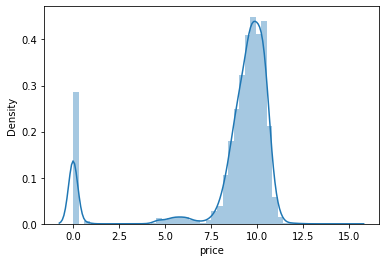

In [ ]:
sns.distplot(y_train_drop)

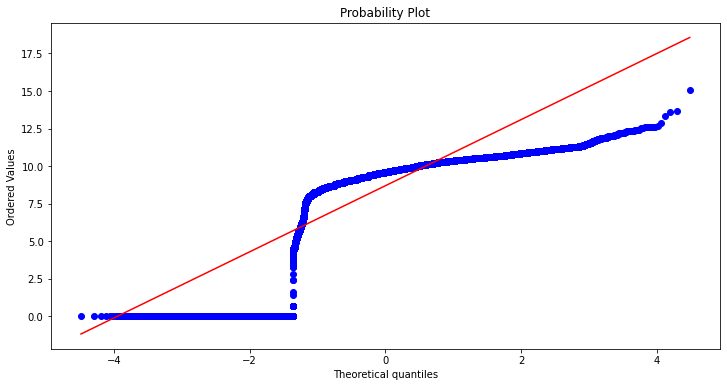

In [ ]:
import pylab
from scipy import stats
plt.figure(figsize=(12, 6))
stats.probplot(y_train_drop, plot=pylab)
pylab.show()

#Catboost

In [ ]:
#select acategorical features
cat_indices = np.where(X_train_drop.dtypes != np.float)[0]
cat_indices

In [ ]:
from sklearn.model_selection import KFold
from math import sqrt


# Function for training the model and calculating the root mean squared error
def Training_Validation_Error_Catboost(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels ,cat_features=cat_indices)
    
    predicted = model.predict(test_data)
    
    rmse = sqrt(mean_squared_error(test_labels,predicted))
    
    print ('rmse = '+str(rmse))
           
    return(rmse)

In [ ]:
kf = KFold(n_splits=10)  # Split the training data into 10 folds

from catboost import CatBoostRegressor
#KFOLD CROSSVAL FOR CATBOOST ALGORITHM

model=CatBoostRegressor(iterations=1500, depth=4, learning_rate=0.03,l2_leaf_reg=10,
                        loss_function='RMSE', random_state=350, verbose=0)
rmse_list=[]

for train_index, val_index in kf.split(X_train_drop):
    X = X_train_drop
    Y = y_train_drop
    X_train,X_val=X.iloc[train_index], X.iloc[val_index]
    Y_train,Y_val=Y.iloc[train_index], Y.iloc[val_index]
    
    rmse=Training_Validation_Error_Catboost(model,train_data = X_train,train_labels = Y_train,test_data = X_val,test_labels = Y_val)
    rmse_list.append(rmse)
    
print("mean rmse is :",np.mean(rmse_list))
print("range is :", max(rmse_list) - min(rmse_list))

rmse = 1.8370422547441967
rmse = 1.8484968732586504
rmse = 1.8472595444926887
rmse = 1.8326859727197395
rmse = 1.85622973893134
rmse = 1.868207392788394
rmse = 1.8397182828422318
rmse = 1.8277948730609404
rmse = 1.8741924877822014
rmse = 1.836413387298402
mean rmse is : 1.8468040807918786
range is : 0.04639761472126103


In [ ]:
import gc
gc.collect()

0

In [ ]:
#prediction
pred = model.predict(X_test_drop)

In [ ]:
from sklearn.metrics import r2_score
print("R2 training", model.score(X_train_drop, y_train_drop))
print("R2 test", model.score(X_test_drop, y_test_drop))
print("R2 prediction", r2_score(y_test_drop, pred))

R2 training 0.6599043306750111
R2 test 0.5758172998143927
R2 prediction 0.5758172998143927
